In [1]:
import IPython.display as ipd
import pandas as pd
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
from scipy.io import wavfile as wav

from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Conv2D, MaxPooling2D, Flatten
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint 
from datetime import datetime 



Using TensorFlow backend.


In [2]:
features_df = pd.read_csv("datasets/featuresdf.csv")

In [3]:
features_df.head()

,id,filepath,duration,class_label
0,1400066,./assets/audio_train/1400066_apples.wav,0.759320,apples
1,1400062,./assets/audio_train/1400062_flowers.wav,0.777324,flowers
2,1400049,./assets/audio_train/1400049_worker.wav,0.571156,worker
3,1400051,./assets/audio_train/1400051_water.wav,0.480091,water
4,1400049,./assets/audio_train/1400049_father.wav,0.448073,father


In [4]:
filepath = f'./assets/audio_train/1400049_father.wav'
audio, sr = librosa.load(filepath)
mfccs = librosa.feature.mfcc(y = audio, sr=sr, n_mfcc=40)

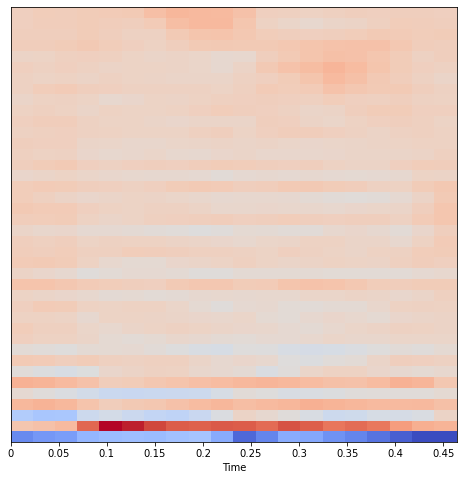

In [5]:
plt.figure(figsize=(8,8))
librosa.display.specshow(mfccs, sr=sr, x_axis = 'time')

In [6]:
mfccs.shape

(40, 20)

In [7]:
mfccs

array([[-1.96346878e+02, -1.79968414e+02, -1.73948914e+02,
        -1.40422562e+02, -1.30837280e+02, -1.27352371e+02,
        -1.30908127e+02, -1.21989059e+02, -1.16357872e+02,
        -1.56346008e+02, -2.33684799e+02, -2.01312592e+02,
        -1.54644608e+02, -1.60986404e+02, -1.86442413e+02,
        -2.01413818e+02, -2.20349533e+02, -2.41758011e+02,
        -2.62189514e+02, -2.62184204e+02],
       [ 1.77322102e+01,  2.43227654e+01,  3.50402946e+01,
         1.25764130e+02,  1.88848480e+02,  1.77813965e+02,
         1.53549866e+02,  1.35759369e+02,  1.32387589e+02,
         1.36715790e+02,  1.34408569e+02,  1.23432144e+02,
         1.43213623e+02,  1.33257278e+02,  1.11394714e+02,
         1.21203140e+02,  1.09763245e+02,  7.17845459e+01,
         5.06944618e+01,  4.38082962e+01],
       [-1.01654694e+02, -1.13328751e+02, -1.11931900e+02,
        -6.33613739e+01, -5.28529968e+01, -6.58507996e+01,
        -7.88319702e+01, -8.26968231e+01, -6.97221756e+01,
        -4.02028198e+01, -9.9

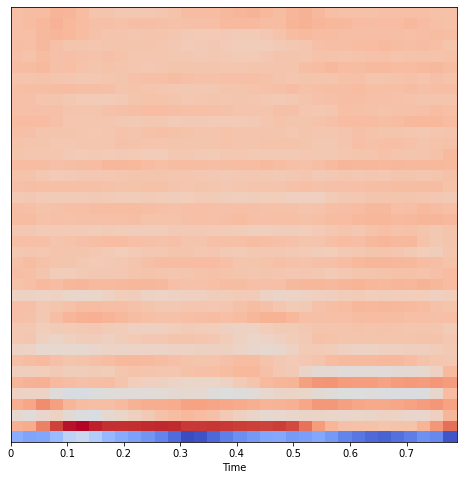

In [8]:
filepath = f'./assets/audio_train/1400062_flowers.wav'
audio, sr = librosa.load(filepath)
mfccs = librosa.feature.mfcc(y = audio, sr=sr, n_mfcc=40)
plt.figure(figsize=(8,8))
librosa.display.specshow(mfccs, sr=sr, x_axis = 'time')

In [9]:
mfccs.shape

(40, 34)

## 3. Preprocessing

There are many ways of preprocessing audio files and the methods of preprocessing is heavily dependent on the type of classification model which will be used.

The model I will be building is:

1. Feedforward Neural Network
2. Convolutional Neural Network
3. Ensemble Method

#### Preproccessing for FNN

There are a few ways to process the audio for a simple feedforward neural network. The first and most common way is to find the average of each coefficient of the MFCC across time, which will give us a shape of (40,1) dimensions. 


In [6]:
def get_mfccs_features(file_list):
    features = {}
    mean = []
    std = []
    delta_mean = []
    delta_std = []
    for f in file_list:
        audio, sr = librosa.load(f) 
        mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=40)
        mfccs_delta = librosa.feature.delta(mfccs)
        
        mfccs_mean = np.mean(mfccs.T,axis=0)
        mean.append(mfccs_mean)
        
        mfccs_std = np.std(mfccs.T,axis=0)
        std.append(mfccs_std)
        
        mfccs_delta_mean = np.mean(mfccs_delta.T,axis=0)
        delta_mean.append(mfccs_delta_mean)
        
        mfccs_delta_std = np.std(mfccs_delta.T,axis=0)
        delta_std.append(mfccs_delta_std)
    
    features['mfccs_mean'] = mean
    features['mfccs_std'] = std
    features['mfccs_delta_mean'] = delta_mean
    features['mfccs_delta_std'] = delta_std
    
    return features

In [7]:
# get all the features

mfccs_features = get_mfccs_features(features_df['filepath'])

In [8]:
# add them into the dataframe

for k, v in mfccs_features.items():
    features_df[k] = v

In [9]:
combined_features = []
for n in range(0,len(features_df)):
    combined_features.append(np.concatenate((features_df['mfccs_mean'][n],features_df['mfccs_std'][n], features_df['mfccs_delta_mean'][n],features_df['mfccs_delta_std'][n])))
features_df['combined_mfccs'] = combined_features

In [75]:
X_1 = features_df['mfccs_mean']

In [76]:
X_1 = np.array(X_1.tolist())

In [77]:
y = to_categorical(le.fit_transform(features_df['class_label'].tolist()))
y = np.array(y)

In [78]:
X_train_1, X_test_1, y_train, y_test = train_test_split(X_1, y, test_size = 0.2, random_state = 42, stratify = y)

**Pre-processing For CNN**

In [24]:
def get_mel(filename):
    audio, sr = librosa.load(filename)
    mel= librosa.feature.melspectrogram(audio, sr=sr)
    mel = librosa.util.fix_length(mel,39)
    return mel.T

In [25]:
features_df['mel'] = features_df['filepath'].map(get_mel)

In [26]:
X_cnn = np.array(features_df['mel'].tolist())

In [27]:
X_cnn.shape

(553, 39, 128)

In [28]:
le = LabelEncoder()
y = to_categorical(le.fit_transform(features_df['class_label'].tolist()))
y = np.array(y)

In [29]:
y.shape

(553, 5)

In [30]:
X_train_cnn, X_test_cnn, y_train_cnn, y_test_cnn = train_test_split(X_cnn, y, test_size = 0.2, random_state = 42, stratify = y)

In [31]:
X_train_cnn = X_train_cnn.reshape(X_train_cnn.shape[0], 39, 128, 1)
X_test_cnn = X_test_cnn.reshape(X_test_cnn.shape[0], 39, 128, 1)


## 4. Modelling

Model 1: Vanilla Base-line model

FNN with MFCCS mean
Dimension = 40
layers = 2

In [79]:
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(40,)))
model.add(Dense(64, activation='relu'))
model.add(Dense(5, activation='softmax'))

In [80]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])

In [84]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             (None, 64)                2624      
_________________________________________________________________
dense_20 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_21 (Dense)             (None, 5)                 325       
Total params: 7,109
Trainable params: 7,109
Non-trainable params: 0
_________________________________________________________________


In [85]:
history = model.fit(X_train_1, y_train, validation_data=(X_test_1, y_test), batch_size=32, epochs = 50, verbose=2)

Train on 442 samples, validate on 111 samples
Epoch 1/50
 - 0s - loss: 16.0236 - accuracy: 0.1765 - val_loss: 6.5337 - val_accuracy: 0.2523
Epoch 2/50
 - 0s - loss: 5.6419 - accuracy: 0.2670 - val_loss: 3.1831 - val_accuracy: 0.3784
Epoch 3/50
 - 0s - loss: 3.0613 - accuracy: 0.3801 - val_loss: 2.7844 - val_accuracy: 0.3874
Epoch 4/50
 - 0s - loss: 2.3701 - accuracy: 0.4095 - val_loss: 2.1627 - val_accuracy: 0.4775
Epoch 5/50
 - 0s - loss: 1.8660 - accuracy: 0.4706 - val_loss: 1.9763 - val_accuracy: 0.4955
Epoch 6/50
 - 0s - loss: 1.5818 - accuracy: 0.5204 - val_loss: 1.8207 - val_accuracy: 0.5135
Epoch 7/50
 - 0s - loss: 1.4109 - accuracy: 0.5792 - val_loss: 1.6948 - val_accuracy: 0.5225
Epoch 8/50
 - 0s - loss: 1.2433 - accuracy: 0.6086 - val_loss: 1.5911 - val_accuracy: 0.5225
Epoch 9/50
 - 0s - loss: 1.0933 - accuracy: 0.6403 - val_loss: 1.5192 - val_accuracy: 0.5676
Epoch 10/50
 - 0s - loss: 1.0670 - accuracy: 0.6561 - val_loss: 1.5347 - val_accuracy: 0.5225
Epoch 11/50
 - 0s - lo

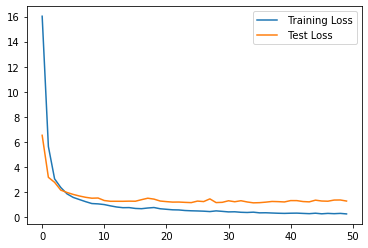

In [86]:
plt.plot(history.history['loss'], label = ' Training Loss')
plt.plot(history.history['val_loss'], label = ' Test Loss')
plt.legend()

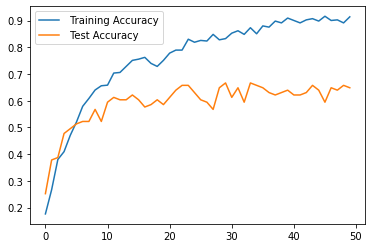

In [87]:
plt.plot(history.history['accuracy'], label = ' Training Accuracy')
plt.plot(history.history['val_accuracy'], label = ' Test Accuracy')
plt.legend()

Model 2

Classifier: FNN
Features: 40 coef * 4 indicators (mean and std, delta mean delta std)
dimension 160


In [88]:
X = np.array(features_df['combined_mfccs'].tolist())
le = LabelEncoder()
y = to_categorical(le.fit_transform(features_df['class_label'].tolist()))
y = np.array(y)

In [89]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)

In [90]:
model2 = Sequential()
model2.add(Dense(64, activation='relu', input_shape=(160,)))
model2.add(Dense(64, activation='relu'))
model2.add(Dense(5, activation='softmax'))

In [91]:
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])

In [92]:
X_train.shape

(442, 160)

In [93]:
history = model2.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=32, epochs = 50, verbose=2)

Train on 442 samples, validate on 111 samples
Epoch 1/50
 - 0s - loss: 4.8457 - accuracy: 0.2285 - val_loss: 2.3253 - val_accuracy: 0.4414
Epoch 2/50
 - 0s - loss: 1.7017 - accuracy: 0.4910 - val_loss: 1.1710 - val_accuracy: 0.6126
Epoch 3/50
 - 0s - loss: 0.9941 - accuracy: 0.6471 - val_loss: 0.9431 - val_accuracy: 0.6937
Epoch 4/50
 - 0s - loss: 0.6691 - accuracy: 0.7783 - val_loss: 0.6677 - val_accuracy: 0.7568
Epoch 5/50
 - 0s - loss: 0.5550 - accuracy: 0.7986 - val_loss: 0.5610 - val_accuracy: 0.7838
Epoch 6/50
 - 0s - loss: 0.4113 - accuracy: 0.8529 - val_loss: 0.4866 - val_accuracy: 0.8108
Epoch 7/50
 - 0s - loss: 0.3460 - accuracy: 0.8869 - val_loss: 0.5873 - val_accuracy: 0.8108
Epoch 8/50
 - 0s - loss: 0.2975 - accuracy: 0.8846 - val_loss: 0.3539 - val_accuracy: 0.8468
Epoch 9/50
 - 0s - loss: 0.2369 - accuracy: 0.9186 - val_loss: 0.4002 - val_accuracy: 0.8649
Epoch 10/50
 - 0s - loss: 0.2111 - accuracy: 0.9276 - val_loss: 0.3992 - val_accuracy: 0.8739
Epoch 11/50
 - 0s - los

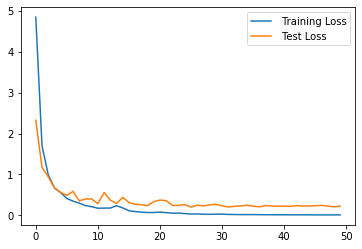

In [94]:
plt.plot(history.history['loss'], label = ' Training Loss')
plt.plot(history.history['val_loss'], label = ' Test Loss')
plt.legend()

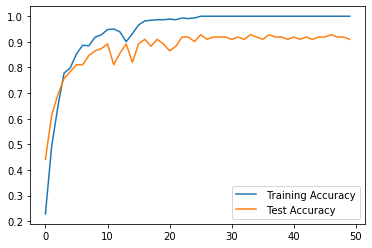

In [95]:
plt.plot(history.history['accuracy'], label = ' Training Accuracy')
plt.plot(history.history['val_accuracy'], label = ' Test Accuracy')
plt.legend()

**CNN**

In [96]:
model3 = Sequential()
model3.add(Conv2D(filters = 6, kernel_size=3, activation = 'relu', input_shape = (39,128,1)))
model3.add(MaxPooling2D(pool_size= (2,2), padding='same'))
model3.add(Conv2D(32, kernel_size=3, activation='relu'))
model3.add(MaxPooling2D(pool_size=(2,2), padding='same'))
model3.add(Flatten())
model3.add(Dense(64, activation = 'relu'))
model3.add(Dense(32, activation = 'relu'))
model3.add(Dense(5, activation = 'softmax'))

In [97]:
model3.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

In [98]:
model3.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 37, 126, 6)        60        
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 19, 63, 6)         0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 17, 61, 32)        1760      
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 9, 31, 32)         0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 8928)              0         
_________________________________________________________________
dense_25 (Dense)             (None, 64)                571456    
_________________________________________________________________
dense_26 (Dense)             (None, 32)               

In [99]:
history = model3.fit(X_train_cnn,
                        y_train_cnn,
                        batch_size=32,
                        validation_data=(X_test_cnn, y_test_cnn),
                        epochs=100,
                        verbose=2)

Train on 442 samples, validate on 111 samples
Epoch 1/100
 - 0s - loss: 7.5350 - accuracy: 0.3643 - val_loss: 2.2357 - val_accuracy: 0.4775
Epoch 2/100
 - 0s - loss: 1.8656 - accuracy: 0.6109 - val_loss: 1.5181 - val_accuracy: 0.5856
Epoch 3/100
 - 0s - loss: 0.8179 - accuracy: 0.7308 - val_loss: 1.3666 - val_accuracy: 0.5946
Epoch 4/100
 - 0s - loss: 0.4639 - accuracy: 0.8258 - val_loss: 1.0101 - val_accuracy: 0.6306
Epoch 5/100
 - 0s - loss: 0.2783 - accuracy: 0.9095 - val_loss: 0.9935 - val_accuracy: 0.7027
Epoch 6/100
 - 0s - loss: 0.2009 - accuracy: 0.9389 - val_loss: 0.8674 - val_accuracy: 0.7387
Epoch 7/100
 - 0s - loss: 0.1429 - accuracy: 0.9683 - val_loss: 0.8322 - val_accuracy: 0.7117
Epoch 8/100
 - 0s - loss: 0.1049 - accuracy: 0.9819 - val_loss: 0.8295 - val_accuracy: 0.7477
Epoch 9/100
 - 0s - loss: 0.0784 - accuracy: 0.9887 - val_loss: 0.7934 - val_accuracy: 0.7207
Epoch 10/100
 - 0s - loss: 0.0602 - accuracy: 0.9977 - val_loss: 0.7994 - val_accuracy: 0.7568
Epoch 11/100


Epoch 86/100
 - 0s - loss: 2.6931e-04 - accuracy: 1.0000 - val_loss: 0.9482 - val_accuracy: 0.8468
Epoch 87/100
 - 0s - loss: 2.6200e-04 - accuracy: 1.0000 - val_loss: 0.9466 - val_accuracy: 0.8468
Epoch 88/100
 - 0s - loss: 2.5744e-04 - accuracy: 1.0000 - val_loss: 0.9530 - val_accuracy: 0.8468
Epoch 89/100
 - 0s - loss: 2.4971e-04 - accuracy: 1.0000 - val_loss: 0.9531 - val_accuracy: 0.8468
Epoch 90/100
 - 0s - loss: 2.4216e-04 - accuracy: 1.0000 - val_loss: 0.9509 - val_accuracy: 0.8468
Epoch 91/100
 - 0s - loss: 2.3725e-04 - accuracy: 1.0000 - val_loss: 0.9536 - val_accuracy: 0.8468
Epoch 92/100
 - 0s - loss: 2.3125e-04 - accuracy: 1.0000 - val_loss: 0.9523 - val_accuracy: 0.8468
Epoch 93/100
 - 0s - loss: 2.2632e-04 - accuracy: 1.0000 - val_loss: 0.9513 - val_accuracy: 0.8468
Epoch 94/100
 - 0s - loss: 2.2088e-04 - accuracy: 1.0000 - val_loss: 0.9561 - val_accuracy: 0.8468
Epoch 95/100
 - 0s - loss: 2.1534e-04 - accuracy: 1.0000 - val_loss: 0.9559 - val_accuracy: 0.8468
Epoch 96/1

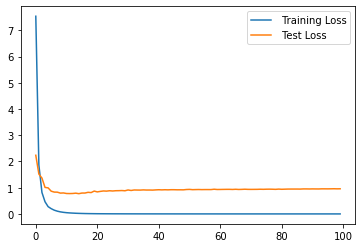

In [100]:
plt.plot(history.history['loss'], label = ' Training Loss')
plt.plot(history.history['val_loss'], label = ' Test Loss')
plt.legend()

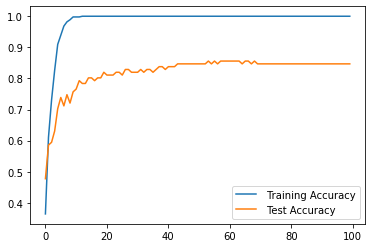

In [101]:
plt.plot(history.history['accuracy'], label = ' Training Accuracy')
plt.plot(history.history['val_accuracy'], label = ' Test Accuracy')
plt.legend()